<a href="https://colab.research.google.com/github/germansuarez017/Sentiment-Analysis-DeepLearningCourse/blob/main/Proyecto_Marvik_Country_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Proyecto Marvick - Country Prediction**
Para este proyecto utilizaremos tweets etiquetados provenientes de países hispanohablantes (Costa Rica, España, México, Perú, Puerto Rico y Uruguay) conseguidos de la página de TASS: Workshop on Semantic Analysis at SEPLN -http://tass.sepln.org/-.

En la primer parte intentaremos predecir el sentimiento (Positivo o Negativo) de los tweets utilizando una red neuronal LSTM.
Para la segunda parte del ejercicio nos concentraremos en predecir el país de origen de los tweets utilizando una red neuronal LSTM y aplicando SMOTE sampling

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
#upgrade library for plotting the confusion matrix
%pip install mlxtend --upgrade

     |████████████████████████████████| 1.3 MB 4.2 MB/s 
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


In [3]:
#clone github repository
! git clone https://github.com/germansuarez017/Sentiment-Analysis-DeepLearningCourse.git

Cloning into 'Sentiment-Analysis-DeepLearningCourse'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 44 (delta 14), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (44/44), done.


# **Parte 1 - Armado de dataframe**

Primero pasaremos los diferentes archivos XML a un dataframe de pandas donde podremos ver la etiqueta del sentimiento asociado y de que país proviene. En una segunda instancia, eliminaremos los tweets que no tienen etiqueta o si la misma es neutral quedándonos solo con los sentimientos positivos y negativos.

In [4]:
#unzip files
! unzip '/content/Sentiment-Analysis-DeepLearningCourse/XML_files.zip' > /dev/null

In [5]:
#function to replace spanish punctuations in order not to loose the letters afterwards
def normalize(s):
    replacements = (
        ('á', 'a'),
        ('é', 'e'),
        ('í', 'i'),
        ('ó', 'o'),
        ('ú', 'u'),
        ('ñ', 'n')
    )
    for a, b in replacements:
        s = s.replace(a, b).replace(a.upper(), b.upper())
    return s

In [6]:
import pandas as pd
import numpy as np
import re
import os
import glob
# this library is needed to read XML files for converting it into CSV
import xml.etree.ElementTree as ET
import shutil
import csv

# Convert xml files into one CSV
# Function that will extract column data for our CSV file
# ET = Element tree is used to parse, navigate, explore and populate xml files
def xml_to_csv(path):
    '''
    Creates a dataframe populated with the XML information
    :param path: path to the folder containing the XML files
    :return: a dataframe with the information from the XML files
    '''
    xml_list = []
    dataset_type = ''
    for xml_file in glob.glob(path + '/*.xml'):
        
        #checks what type of dataset is
        if 'train' in xml_file:
          dataset_type = 'train'
        if 'test' in xml_file:
          dataset_type = 'test'
        if 'dev' in xml_file:
          dataset_type = 'val'
        
        #checks country
        country = xml_file[36:38]
        
        tree = ET.parse(xml_file)                           # Reads the xml file and initialize the tree
        root = tree.getroot()
        
        for tweet in root.findall('tweet'):
          value = (normalize(tweet.find('content').text),
                   tweet.find('date').text,
                   tweet.find('sentiment')[0][0].text,
                   country,
                   dataset_type)
          xml_list.append(value)
    column_name = ['tweet_unclean', 'date', 'sentiment', 'country', 'dataset_type']
    xml_df = pd.DataFrame(xml_list, columns = column_name)
    return xml_df

In [7]:
#converts xml files into csv
path_xml = '/content/XML_files'
df = xml_to_csv(path_xml)

In [8]:
#discard test tweets, they are untagged
df = df[df.dataset_type != 'test']

#lets stay with the tweets, sentiment and country
df = df[['tweet_unclean', 'sentiment', 'country']]

#discard NEU or NONE tags
df = df[df.sentiment != 'NEU']
df = df[df.sentiment != 'NONE']

In [9]:
#converts dataframe to csv
# path = '/content/Sentiment-Analysis-DeepLearningCourse'
# df.to_csv(path + '/' + 'tweetslatinamerica.csv')

Viendo el gráfico debajo podemos concluir que el dataset está relativamente balanceado.

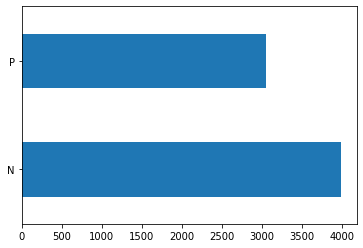

In [10]:
#check how many positive and negative tags are in the dataset
ax = df['sentiment'].value_counts(sort=False).plot(kind='barh')

# **Parte 2 - Limpieza de tweets**
En esta parte limpiaremos los tweets de la siguiente manera:
- Pasaremos todo a lowercase
- Quitaremos punctuaciones y símbolos
- Quitaremos las referencias a los retweets (rt)
- Quitaremos las stopwords
- Haremos un stemmering, intentando achicar el vocabulario total
- Quitaremos todos los caractéres que no sean alfabéticos

Luego utilizaremos CountVectorizer de ScikitLearn para contar cuantas palabras tiene el dataset y obtener las más utilizadas.

In [11]:
#nltk librería de análisis de lenguaje
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('spanish')

#imports spanish stopwords
nltk.download('stopwords')
stopwords = set(stopwords.words('spanish'))

#function to clean tweets
def clean_tweets(tweet):
  #lowercase
  tweet = tweet.lower()
  #removes punctiations
  tweet = re.sub(r'[^a-zA-Z0-9]', ' ', tweet)
  #delete retweets references
  tweet = tweet.replace(' rt ', '')
  #remove stopwords
  tweet = [word for word in tweet.split(sep = ' ') if word not in stopwords]
  #stemming words
  tweet = [stemmer.stem(word) for word in tweet]
  #stay with alphanumeric characters
  tweet = [word for word in tweet if word.isalpha()]

  return ' '.join(tweet)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [12]:
#apply function to clean text creating a new column that will have the cleaned text
df['tweet'] = df['tweet_unclean'].apply(lambda x: clean_tweets(x))

In [13]:
#check how it looks the cleaned tweets¿¨
for i in range(0,5):
  print('unclean: {}'.format(df['tweet_unclean'].iloc[i]),'\n', 'clean: {}'.format(df['tweet'].iloc[i]))
  print('-----------------------------')


unclean: El primer ano que empece a vivir lejos de mi casa mami me llamaba todos los dias, ya no, se pasan los dias y nada, el amor se acaba 
 clean: prim ano empec viv lej cas mami llam dias pas dias amor acab
-----------------------------
unclean: @TomasZumad Ando peor que Tinkerbell en sus anos mozos. ¿Y si nos vemos hoy? Tia se fue a la romeria, estoy sola y tengo maqueta q hacer. 
 clean: tomaszum ando peor tinkerbell anos moz si vem hoy tia romeri sol maquet q hac
-----------------------------
unclean: Estabamos subrayando en Sociales y el apellido de un mae era "Kagame", y soy tan inmadura que no pare de reirme por casi toda la leccion. 
 clean: estab subray social apell mae kagam tan inmadur par reirm casi tod leccion
-----------------------------
unclean: "El es raro, pero es hay q estar demasiado mal de la cabeza para querer estar con alguien tan danada como yo". -Yo, hablando con mi papa. 
 clean: rar q demasi mal cabez quer algui tan dan habl pap
---------------------------

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

#counts how many words are in the dataset
countvectorizer = CountVectorizer()
countVector = countvectorizer.fit_transform(df['tweet'])
print('{} Number of reviews has {} words'.format(countVector.shape[0], countVector.shape[1]))

7037 Number of reviews has 9977 words


In [15]:
#use countvectorizer to create a dataframe with all the words in columns
count_vect_df = pd.DataFrame(countVector.toarray(), columns=countvectorizer.get_feature_names())
count_vect_df.head()

,aaa,aaaa,aaaaaay,aaaaajajajajajajajajaj,aaah,aaron,ab,abac,abaj,abandon,abandonadisim,abarc,abarrot,abast,abat,abby,abcdesignat,abdiel,abdielsmusic,abdom,abedul,abeftlouis,abel,aberron,abieeflor,abiert,abis,ablo,abord,abordaj,abossus,abrac,abraham,abrahamers,abrahammateoenuruguay,abrahammateomus,abram,abraz,abrazar,abrazart,...,zaharapop,zahirecoronel,zamruv,zanain,zapat,zapatill,zapd,zapejuan,zapot,zaragoz,zarcer,zarp,zaval,zayn,zeld,zeped,zepol,zer,zeroanim,zet,zgz,zi,zick,ziempr,zinoscrew,zoestrang,zombi,zombiepolar,zommix,zon,zonz,zoo,zorr,zoy,zum,zumb,zumbadisim,zumoo,zung,zylx
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [16]:
#shows most used words
count = pd.DataFrame(count_vect_df.sum())
countdf = count.sort_values(0,ascending=False).head(20)
countdf[0:9]

,0
buen,774
si,653
mas,600
hac,525
mejor,410
quier,400
sol,391
ser,377
pas,372


# **Parte 3 - Estudio del dataset**
Primeo estudiaremos un poco el dataset, veremos cuantos tweets tenemos para cada uno de los países presentes en proporción del total.
Viendo el gráfico circular se puede apreciar que España es el país que cuenta con más tweets, contrario a Puerto Rico que apenas representa un 7% de los tweets totales. Debido a la poca proporción de tweets para este último país, lo excluiremos del análisis.

In [17]:
# =======================================
# COUNTRY PREDICTION
# =======================================

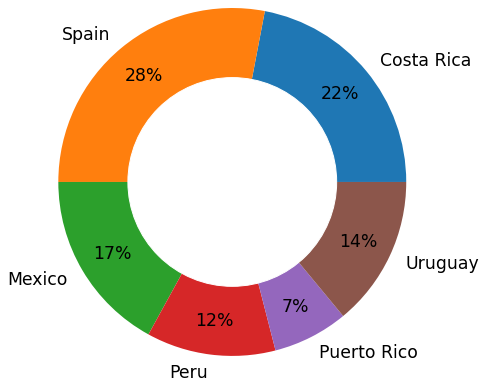

In [18]:
#creates pie chart to see the how many tweets has each country
import matplotlib.pyplot as plt

#group by countries
country_counts = df.groupby(['country'])['country'].count()

#same groupby but in percentage (not used actually)
country_percentage = round((country_counts/country_counts.sum())*100)

#change country names for more suitables
country_percentage.rename(index= {'CR':'Costa Rica', 'ES': 'Spain', 'MX': 'Mexico', 'PE': 'Peru', 'PR': 'Puerto Rico', 'UY':'Uruguay',}, inplace=True)

#get the labels
country_labels = country_percentage.index

# colors=['green', 'blue', 'red', 'yellow', 'orange', 'brown']
#create a circle for the center of the plot
circle = plt.Circle( (0,0), radius = 1.2, color='white')
plt.pie(country_percentage, labels = country_labels, radius = 2, textprops = {'fontsize':'xx-large'}, autopct='%1.0f%%', pctdistance=0.8, labeldistance=1.1)
p=plt.gcf()
p.gca().add_artist(circle)
plt.show()

Para las siguientes partes procederemos de manera similar a cuando hicimos el análisis de sentimiento, la única diferencia es que ahora nuestras etiquetas son los países y nos olvidaremos de los sentimientos.

In [19]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#exclude Puerto Rico due to very low samples
df_country = df[df.country != 'PR']

#the features will be the amount of words
max_features = countVector.shape[1]

#initilize Tokenizer
tokenizer = Tokenizer(num_words = max_features, split =' ')

#training
tokenizer.fit_on_texts(df_country['tweet'].values)

#transforms tweets in numeric arrays
X1_c = tokenizer.texts_to_sequences(df_country['tweet'].values)

#transforms all sequences into same length
X_c = pad_sequences(X1_c)

In [20]:
#instead of predicting the sentiment we ar going to predict the country
from sklearn.model_selection import train_test_split

#dummies for country
Y_c = pd.get_dummies(df_country['country']).values

#train and test separation
X_train_c, X_test_c, Y_train_c, Y_test_c = train_test_split(X_c, Y_c, test_size = 0.33, random_state = 42)

In [21]:
#create validation set with 1000 tweets
validation_size = 500

X_validate_c = X_test_c[-validation_size:]
Y_validate_c = Y_test_c[-validation_size:]
X_test_c = X_test_c[:-validation_size]
Y_test_c = Y_test_c[:-validation_size]

# **Parte 4 - Ensamble de la red neuronal y entrenamiento**
La red estará compuesta por las siguientes capas:
- Embedding con un output_dim de 200
- Densa con 32 unidades y activación relu
- Dropout (0.25)
- LSTM de 32 unidades
- Droput (0.5)
- Densa con 5 unidades (una por país) y activación softmax

Compilaremos el modelo utilizando el optimizador adam, la función de los categorical_crossentropy y accuracy para las métricas. Entrenaremos con 10 epochs y un batch_size de 128. 


In [22]:
#assembling of neural network
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Flatten

# foir this part the embedding dimension will larger than the sentiment part
embed_dim = 200

model_country = Sequential()
model_country.add(Embedding(input_dim = max_features, output_dim = embed_dim, input_length = X_c.shape[1]))
model_country.add(Dense(32, activation = 'relu'))
model_country.add(Dropout(0.25))
model_country.add(LSTM(32, dropout = 0.2, recurrent_dropout = 0.2))
model_country.add(Dropout(0.5))
model_country.add(Dense(Y_c.shape[1], activation = 'softmax'))
model_country.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 22, 200)           1995400   
_________________________________________________________________
dense (Dense)                (None, 22, 32)            6432      
_________________________________________________________________
dropout (Dropout)            (None, 22, 32)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 165       
Total params: 2,010,317
Trainable params: 2,010,317
Non-trainable params: 0
______________________________________________

In [23]:
#compile and train model
batch_size = 128
model_country.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model_country.fit(X_train_c, Y_train_c, batch_size = batch_size, epochs = 10, validation_data = (X_validate_c, Y_validate_c))

Epoch 1/10
35/35 [==============================] - 27s 148ms/step - loss: 1.5982 - accuracy: 0.2522 - val_loss: 1.5477 - val_accuracy: 0.2940
Epoch 2/10
35/35 [==============================] - 4s 112ms/step - loss: 1.5531 - accuracy: 0.3056 - val_loss: 1.5234 - val_accuracy: 0.2940
Epoch 3/10
35/35 [==============================] - 4s 113ms/step - loss: 1.4599 - accuracy: 0.3615 - val_loss: 1.3546 - val_accuracy: 0.4560
Epoch 4/10
35/35 [==============================] - 4s 114ms/step - loss: 1.0692 - accuracy: 0.5922 - val_loss: 1.2125 - val_accuracy: 0.5360
Epoch 5/10
35/35 [==============================] - 4s 117ms/step - loss: 0.6998 - accuracy: 0.7783 - val_loss: 1.2273 - val_accuracy: 0.5820
Epoch 6/10
35/35 [==============================] - 4s 117ms/step - loss: 0.4572 - accuracy: 0.8607 - val_loss: 1.3393 - val_accuracy: 0.6020
Epoch 7/10
35/35 [==============================] - 4s 114ms/step - loss: 0.3397 - accuracy: 0.9083 - val_loss: 1.3329 - val_accuracy: 0.6120
Epoch

In [24]:
#check score and accuracy in test set
score_c,acc_c = model_country.evaluate(X_test_c, Y_test_c, batch_size = batch_size)
print("Score: %.2f" % (score_c))
print("Acc: %.2f" % (acc_c))

14/14 [==============================] - 0s 8ms/step - loss: 1.7149 - accuracy: 0.5735
Score: 1.71
Acc: 0.57


In [25]:
import numpy as np
cr, es, mx, pe, uy = 0, 0, 0, 0, 0
cr_cnt, es_cnt, mx_cnt, pe_cnt, uy_cnt = 0, 0, 0, 0, 0

for x in range(len(X_validate_c)):
    
    result = model_country.predict(X_test_c[x].reshape(1,X_test_c.shape[1]),batch_size=1,verbose = 2)[0]

    if np.argmax(result) == np.argmax(Y_test_c[x]):

        if np.argmax(Y_test_c[x]) == 0:
          cr += 1
        if np.argmax(Y_test_c[x]) == 1:
          es +=1
        if np.argmax(Y_test_c[x]) == 2:
          mx +=1
        if np.argmax(Y_test_c[x]) == 3:
          pe +=1
        if np.argmax(Y_test_c[x]) == 4:
          uy +=1

    if np.argmax(Y_test_c[x]) == 0:
      cr_cnt += 1
    if np.argmax(Y_test_c[x]) == 1:
      es_cnt += 1
    if np.argmax(Y_test_c[x]) == 2:
      mx_cnt += 1
    if np.argmax(Y_test_c[x]) == 3:
      pe_cnt += 1
    if np.argmax(Y_test_c[x]) == 4:
      uy_cnt += 1
    

print("costa rica_acc", round(cr/cr_cnt*100,1), "%")
print("spain_acc", round(es/es_cnt*100,1), "%")
print("mexico_acc", round(mx/mx_cnt*100,1), "%")
print("peru_acc", round(pe/pe_cnt*100,1), "%")
print("uruguay_acc", round(uy/uy_cnt*100,1), "%")


1/1 - 1s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1

<Figure size 432x288 with 0 Axes>

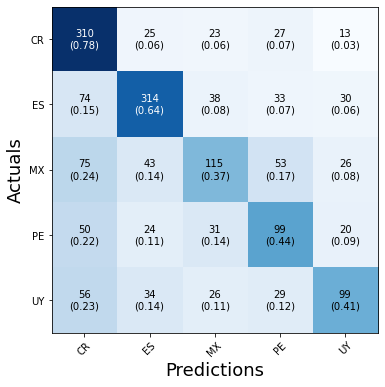

In [26]:
#using the confusion matrix is easier to calculate accuracy and recall

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

y_pred= model_country.predict(X_test_c).round()

# calculates confusion matrix
cnf_matrix = confusion_matrix(Y_test_c.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=3)

# graph confusion matrix
labels = ['CR', 'ES', 'MX', 'PE', 'UY']
plt.figure()
plot_confusion_matrix(conf_mat = cnf_matrix, figsize = (6,6), class_names = labels, show_absolute = True, show_normed = True)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.show()

In [27]:
def calculates_acc_recall (country, cnf_matrix):
  countries = ['CR', 'ES', 'MX', 'PE', 'UY']
  #get country index
  i = countries.index(country)
  #calculates accuracy
  country_recall = cnf_matrix[i][i]/cnf_matrix[i].sum()
  #calculates recall
  country_precision = cnf_matrix.transpose()[i][i]/cnf_matrix.transpose()[i].sum()
  
  print('{} recall: {}'.format(country, round(country_recall*100,1)), '%', '\n'
              '{} precision: {}'.format(country, round(country_precision*100,1)), '%')
  
  return round(country_recall*100,1), round(country_precision*100,1)

In [28]:
countries = ['CR', 'ES', 'MX', 'PE','UY']
for country in countries:
  calculates_acc_recall(country, cnf_matrix)
  print('\n')

CR recall: 77.9 % 
CR precision: 54.9 %


ES recall: 64.2 % 
ES precision: 71.4 %


MX recall: 36.9 % 
MX precision: 49.4 %


PE recall: 44.2 % 
PE precision: 41.1 %


UY recall: 40.6 % 
UY precision: 52.7 %




# **Parte 5 - Balanceo de dataset utilizando SMOTE sampling**
Para esta parte utilizaremos SMOTE sampling con el objetivo de tener la misma cantidad de muestras para cada país, generando un dataset más balanceado. Tanto la red neuronal como los hiper-parámetros se mantienen igual de modo de poder comparar resultados.

In [29]:
#Lets balance a bit the dataset

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Sampling
X_resample, y_resample = SMOTE().fit_sample(X_train_c, Y_train_c)

# transforms into nparray
y_resample = np.array(y_resample)
X_resample = np.array(X_resample)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/loca

In [30]:
print ('Total datos antes del sampling : ' + str(len(X_train_c)))
print ('Total datos de Costa Rica: '+ str(Y_train_c.transpose()[0].sum()))
print ('Total datos de España: '+ str(Y_train_c.transpose()[1].sum()))
print ('Total datos de Mexico: '+ str(Y_train_c.transpose()[2].sum()))
print ('Total datos de Peru: '+ str(Y_train_c.transpose()[3].sum()))
print ('Total datos de Uruguay: '+ str(Y_train_c.transpose()[4].sum()))
print('\n')
print ('Total datos después del sampling : ' + str(len(X_resample)))
print ('Total datos de Costa Rica: '+ str(y_resample.transpose()[0].sum()))
print ('Total datos de España: '+ str(y_resample.transpose()[1].sum()))
print ('Total datos de Mexico: '+ str(y_resample.transpose()[2].sum()))
print ('Total datos de Peru: '+ str(y_resample.transpose()[3].sum()))
print ('Total datos de Uruguay: '+ str(y_resample.transpose()[4].sum()))


Total datos antes del sampling : 4397
Total datos de Costa Rica: 1010
Total datos de España: 1303
Total datos de Mexico: 825
Total datos de Peru: 563
Total datos de Uruguay: 696


Total datos después del sampling : 6515
Total datos de Costa Rica: 1303
Total datos de España: 1303
Total datos de Mexico: 1303
Total datos de Peru: 1303
Total datos de Uruguay: 1303


In [31]:
#assembling of neural network for data resampled
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

embed_dim = 200

model_country_resampled = Sequential()
model_country_resampled.add(Embedding(input_dim = max_features, output_dim = embed_dim, input_length = X_c.shape[1]))
model_country_resampled.add(Dense(32, activation = 'relu'))
model_country_resampled.add(Dropout(0.25))
model_country_resampled.add(LSTM(32, dropout = 0.2, recurrent_dropout = 0.2))
model_country_resampled.add(Dropout(0.5))
model_country_resampled.add(Dense(Y_c.shape[1], activation = 'softmax'))
model_country_resampled.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 22, 200)           1995400   
_________________________________________________________________
dense_2 (Dense)              (None, 22, 32)            6432      
_________________________________________________________________
dropout_2 (Dropout)          (None, 22, 32)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 165       
Total params: 2,010,317
Trainable params: 2,010,317
Non-trainable params: 0
____________________________________________

In [32]:
#compile and train model using resampled data
batch_size = 128
model_country_resampled.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model_country_resampled.fit(X_resample, y_resample, batch_size = batch_size, epochs = 10, validation_data = (X_validate_c, Y_validate_c))

Epoch 1/10
51/51 [==============================] - 10s 131ms/step - loss: 1.6093 - accuracy: 0.1981 - val_loss: 1.6016 - val_accuracy: 0.3120
Epoch 2/10
51/51 [==============================] - 6s 114ms/step - loss: 1.5881 - accuracy: 0.3172 - val_loss: 1.5433 - val_accuracy: 0.3820
Epoch 3/10
51/51 [==============================] - 6s 109ms/step - loss: 1.4240 - accuracy: 0.4360 - val_loss: 1.3596 - val_accuracy: 0.4520
Epoch 4/10
51/51 [==============================] - 6s 113ms/step - loss: 0.9763 - accuracy: 0.6617 - val_loss: 1.2903 - val_accuracy: 0.5000
Epoch 5/10
51/51 [==============================] - 6s 112ms/step - loss: 0.6699 - accuracy: 0.7801 - val_loss: 1.3069 - val_accuracy: 0.5540
Epoch 6/10
51/51 [==============================] - 6s 113ms/step - loss: 0.4974 - accuracy: 0.8418 - val_loss: 1.2742 - val_accuracy: 0.6120
Epoch 7/10
51/51 [==============================] - 5s 108ms/step - loss: 0.3794 - accuracy: 0.8871 - val_loss: 1.3882 - val_accuracy: 0.5760
Epoch

In [33]:
#check score and accuracy in test set
score_c,acc_c = model_country_resampled.evaluate(X_test_c, Y_test_c, batch_size = batch_size)
print("Score: %.2f" % (score_c))
print("Acc: %.2f" % (acc_c))

14/14 [==============================] - 0s 9ms/step - loss: 1.7857 - accuracy: 0.5669
Score: 1.79
Acc: 0.57


<Figure size 432x288 with 0 Axes>

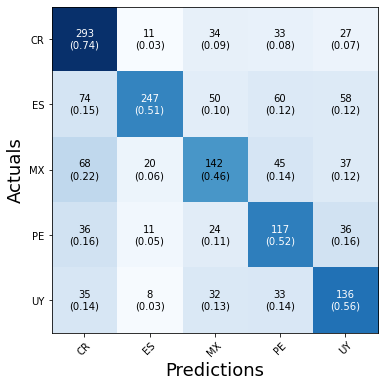

In [34]:
#using the confusion matrix is easier to calculate accuracy and recall

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

y_pred= model_country_resampled.predict(X_test_c).round()

# calculates confusion matrix
cnf_matrix_resampled = confusion_matrix(Y_test_c.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=3)

# graph confusion matrix
labels = ['CR', 'ES', 'MX', 'PE', 'UY']
plt.figure()
plot_confusion_matrix(conf_mat = cnf_matrix_resampled, figsize = (6,6), class_names = labels, show_absolute = True, show_normed = True)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.show()

In [35]:
countries = ['CR', 'ES', 'MX', 'PE', 'UY']
for country in countries:
  calculates_acc_recall(country, cnf_matrix_resampled)
  print('\n')

CR recall: 73.6 % 
CR precision: 57.9 %


ES recall: 50.5 % 
ES precision: 83.2 %


MX recall: 45.5 % 
MX precision: 50.4 %


PE recall: 52.2 % 
PE precision: 40.6 %


UY recall: 55.7 % 
UY precision: 46.3 %




# **Comparación**

In [36]:
#before SMOTE sampling
cr_rec, cr_pre = calculates_acc_recall('CR', cnf_matrix)
es_rec, es_pre = calculates_acc_recall('ES', cnf_matrix)
mx_rec, mx_pre = calculates_acc_recall('MX', cnf_matrix)
pe_rec, pe_pre = calculates_acc_recall('PE', cnf_matrix)
uy_rec, uy_pre = calculates_acc_recall('UY', cnf_matrix)

#after SMOTE sampling
cr_rec_smote, cr_pre_smote = calculates_acc_recall('CR', cnf_matrix_resampled)
es_rec_smote, es_pre_smote = calculates_acc_recall('ES', cnf_matrix_resampled)
mx_rec_smote, mx_pre_smote = calculates_acc_recall('MX', cnf_matrix_resampled)
pe_rec_smote, pe_pre_smote = calculates_acc_recall('PE', cnf_matrix_resampled)
uy_rec_smote, uy_pre_smote = calculates_acc_recall('UY', cnf_matrix_resampled)

#recall variation
cr_rec_var = cr_rec_smote - cr_rec
es_rec_var = es_rec_smote - es_rec
mx_rec_var = mx_rec_smote - mx_rec
pe_rec_var = pe_rec_smote - pe_rec
uy_rec_var = uy_rec_smote - uy_rec

#precision variation
cr_pre_var = cr_pre_smote - cr_pre
es_pre_var = es_pre_smote - es_pre
mx_pre_var = mx_pre_smote - mx_pre
pe_pre_var = pe_pre_smote - pe_pre
uy_pre_var = uy_pre_smote - uy_pre

CR recall: 77.9 % 
CR precision: 54.9 %
ES recall: 64.2 % 
ES precision: 71.4 %
MX recall: 36.9 % 
MX precision: 49.4 %
PE recall: 44.2 % 
PE precision: 41.1 %
UY recall: 40.6 % 
UY precision: 52.7 %
CR recall: 73.6 % 
CR precision: 57.9 %
ES recall: 50.5 % 
ES precision: 83.2 %
MX recall: 45.5 % 
MX precision: 50.4 %
PE recall: 52.2 % 
PE precision: 40.6 %
UY recall: 55.7 % 
UY precision: 46.3 %


In [37]:
models = pd.DataFrame({'Country': ['Costa Rica', 'Spain', 'Mexico','Perú', 'Uruguay'],
                      'Recall before SMOTE': [cr_rec, es_rec,mx_rec, pe_rec, uy_rec ],
                      'Precision before SMOTE' : [cr_pre, es_pre, mx_pre, pe_pre, uy_pre],
                      'Recall after SMOTE': [cr_rec_smote, es_rec_smote, mx_rec_smote, pe_rec_smote, uy_rec_smote ],
                      'Precision after SMOTE': [cr_pre_smote, es_pre_smote, mx_pre_smote, pe_pre_smote, uy_pre_smote],
                      'Recall Variation': [cr_rec_var, es_rec_var, mx_rec_var, pe_rec_var, uy_rec_var],
                      'Precision Variation': [cr_pre_var, es_pre_var, mx_pre_var, pe_pre_var, uy_pre_var]})
models.sort_values(by='Country', ascending=True)

,Country,Recall before SMOTE,Precision before SMOTE,Recall after SMOTE,Precision after SMOTE,Recall Variation,Precision Variation
0,Costa Rica,77.9,54.9,73.6,57.9,-4.3,3.0
2,Mexico,36.9,49.4,45.5,50.4,8.6,1.0
3,Perú,44.2,41.1,52.2,40.6,8.0,-0.5
1,Spain,64.2,71.4,50.5,83.2,-13.7,11.8
4,Uruguay,40.6,52.7,55.7,46.3,15.1,-6.4
